<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/odev86_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Regression Project
Data Set: [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing) <br>
*\"Can you cut the time a Mercedes-Benz spends on the test bench?\"*

In [22]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
#import warnings
#warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
title_font = {"family":"sans-serif", 
              "color":"gray", 
              "size":16, 
              "weight":"bold"}
axis_font = {"family":"sans", 
              "color":"gray", 
              "size":14, 
              "weight":"normal"}

train = pd.read_csv("/content/drive/My Drive/MertColab/proje2/train.csv")
test = pd.read_csv("/content/drive/My Drive/MertColab/proje2/test.csv")

# Let's convert the data of these columns to numeric values.
# e.g a=1, c=3, z=26, aa=27, ac=29, ba=54, bd=57 etc.
from string import ascii_lowercase

for data in (test, train):
    for col in data.columns[1:10]:
        temp = 1
        for var1 in ascii_lowercase:
            var2 = "a" + var1
            var3 = "b" + var1
            data[col] = data[col].replace(var1, temp)
            data[col] = data[col].replace(var2, temp+26)
            data[col] = data[col].replace(var3, temp+26*2)
            temp+=1
        data[col] = data[col].astype("int64")    # data types are also changed.

# Standardization of these numeric values
from sklearn.preprocessing import scale

for col in train.columns[2:10]:
    train[col] = scale(train[col])
    test[col] = scale(test[col])

# REGRESSION MODELS
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

X = train.iloc[:, 2:]
Y = train.y
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)
results_model = sm.OLS(y_train, x_train)
results_ols = results_model.fit()
print("\nAdjusted R-square value of OLS Model: %.4f" %results_ols.rsquared_adj)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
lasso_CV = LassoCV(alphas=np.logspace(-1, 10, 10), cv=10).fit(x_train, y_train)
lasso_score = lasso_CV.score(x_train, y_train)
print("Adjusted R-square value of Lasso Model: %.4f" %lasso_score)

ridge_CV = RidgeCV(alphas=np.logspace(-4, 100, 10), cv=10).fit(x_train, y_train)
ridge_score = ridge_CV.score(x_train,y_train)
print("Adjusted R-square value of Ridge Model: %.4f" %ridge_score)

elasticNet_CV = ElasticNetCV(alphas=np.logspace(-6, 100, 20), l1_ratio=0.5, cv=10).fit(x_train, y_train)
elasticNet_score = elasticNet_CV.score(x_train, y_train)
print("Adjusted R-square value of ElasticNet Model: %.4f" %elasticNet_score)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Adjusted R-square value of OLS Model: 0.5575
Adjusted R-square value of Lasso Model: 0.5386
Adjusted R-square value of Ridge Model: 0.5915
Adjusted R-square value of ElasticNet Model: 0.5913


***
# Ödev 8.6 - XGBoost ile Boosting (Project 2)

In [23]:
import xgboost as xgb
# regressor:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

x_train.drop("const", inplace=True, axis="columns")

In [24]:
project2_dmatrix = xgb.DMatrix(data=X, label=Y)
parameters = {"objective":"reg:squarederror", 
              "max_depth":4, 
              "silent":False,
              "n_jobs":-1, 
              "colsample_bytree":0.3, 
              "gamma":0.1, 
              "learning_rate":0.3, 
              "min_child_weight":3, 
              "n_estimators":100}

project2_cv = xgb.cv(params=parameters,
                     dtrain=project2_dmatrix, 
                     nfold=5, early_stopping_rounds=5, metrics="rmse", 
                     as_pandas=True, seed=42, num_boost_round=100)

project2_cv.sort_values(by="test-rmse-mean").head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
20,7.897484,0.242364,8.400101,1.015267
19,7.922876,0.245487,8.406062,1.021981
16,8.014523,0.269054,8.408408,1.029917
17,7.986022,0.264618,8.411254,1.030927
18,7.963943,0.260791,8.411884,1.030776


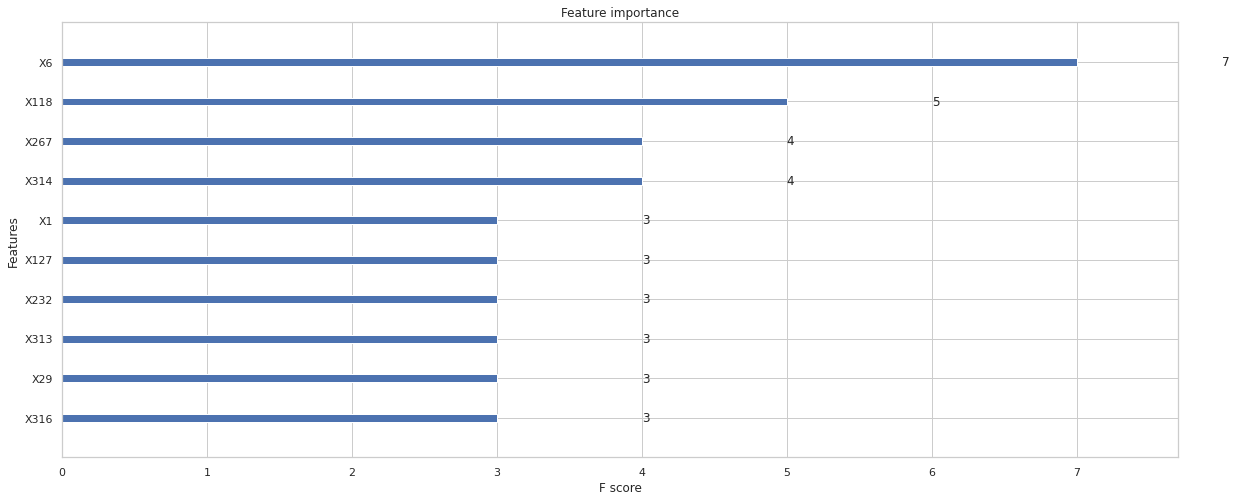

In [25]:
project2_model = xgb.train(params=parameters, 
                           dtrain=project2_dmatrix, 
                           num_boost_round=10)
ax1 = xgb.plot_importance(project2_model, max_num_features=10)
ax1.figure.set_size_inches(20, 8)
plt.show()

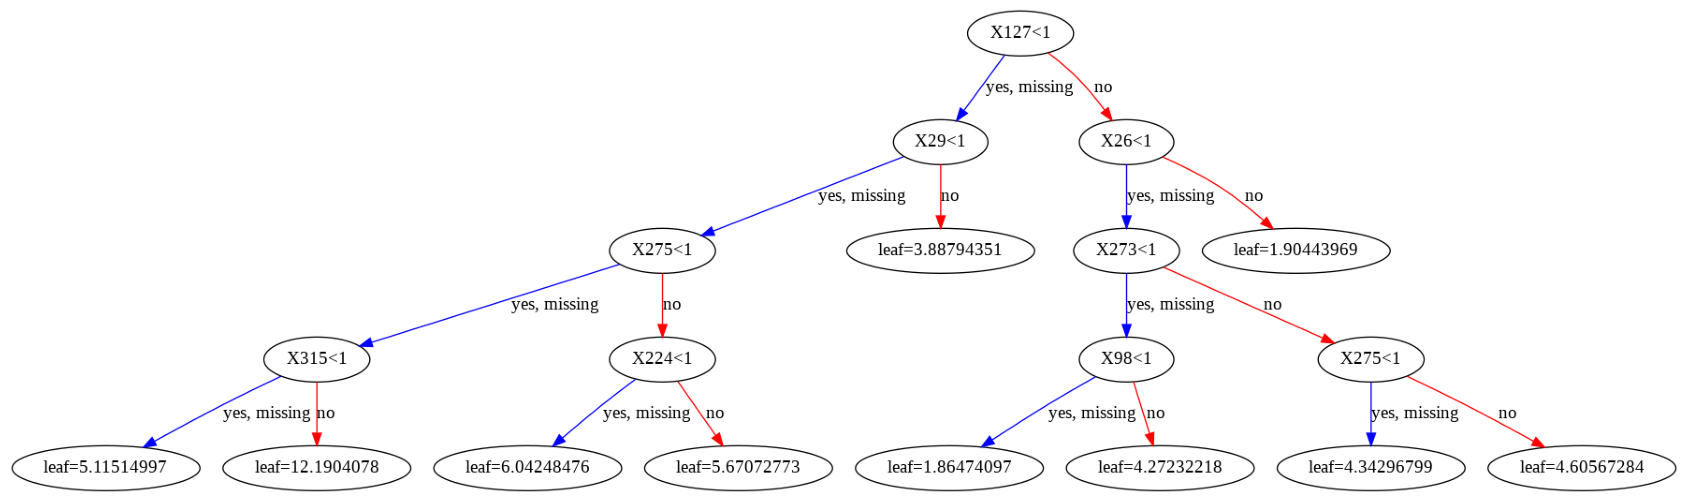

In [26]:
ax2 = xgb.plot_tree(project2_model, num_trees=5)
ax2.figure.set_size_inches(30,30)
plt.show()

In [ ]:
# simple xgboost regression
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", seed=42)
xg_reg.fit(x_train, y_train)
y_predict = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"RMSE        : {rmse:.3f}")
print(f"Train score : {xg_reg.score(x_train, y_train):.4f}")
print(f"Test score  : {xg_reg.score(x_test, y_test):.4f}")

RMSE        : 7.956
Train score : 0.6111
Test score  : 0.5935


In [ ]:
%%time
# with GridSearchCV
xg_reg_gridModel = xgb.XGBRegressor(seed=42)
parameters = {"objective":["reg:squarederror"], 
              "max_depth":[2,3,4], 
              "silent":[False],
              "n_jobs":[-1], 
              "colsample_bytree":[0.1, 0.4, 0.8], 
              "gamma":[0.1, 0.5], 
              "learning_rate":[0.3, 0.5], 
              "min_child_weight":[4], 
              "n_estimators":[100]}
grid_cv = GridSearchCV(estimator=xg_reg_gridModel, param_grid=parameters, cv=5)
grid_cv.fit(x_train, y_train)
y_predict = grid_cv.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"RMSE: {rmse:.3f}")
print("Best parameters  :", grid_cv.best_params_)
print("Best train score :", grid_cv.best_score_)

RMSE: 8.026
Best parameters  : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 100, 'n_jobs': -1, 'objective': 'reg:squarederror', 'silent': False}
Best train score : 0.5548072466252172
CPU times: user 3min 37s, sys: 287 ms, total: 3min 37s
Wall time: 3min 37s


In [ ]:
print(f"Best train score : {grid_cv.score(x_train, y_train):.4f}")
print(f"Best test score  : {grid_cv.score(x_test, y_test):.4f}")

Best train score : 0.6107
Best test score  : 0.5863


In [ ]:
results = pd.DataFrame(grid_cv.cv_results_)
results = results[["param_learning_rate", "param_gamma", 
                   "param_colsample_bytree", 
                   "param_max_depth", "mean_test_score"]]
results = results.sort_values(by="mean_test_score", ascending=False)
results.head(10)

,param_learning_rate,param_gamma,param_colsample_bytree,param_max_depth,mean_test_score
30,0.3,0.5,0.8,2,0.554807
24,0.3,0.1,0.8,2,0.554807
0,0.3,0.1,0.1,2,0.554792
6,0.3,0.5,0.1,2,0.554792
12,0.3,0.1,0.4,2,0.552654
18,0.3,0.5,0.4,2,0.552654
21,0.5,0.5,0.4,2,0.543471
15,0.5,0.1,0.4,2,0.543471
1,0.3,0.1,0.1,3,0.543374
7,0.3,0.5,0.1,3,0.542832


---
***
---

# Project 3: Classification Project
Data Set: [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) <br>
*\"Analyze how travelers in February 2015 expressed their feelings on Twitter\"*

In [27]:
%matplotlib inline

# calling our honor guest:
tweets = pd.read_csv("/content/drive/My Drive/MertColab/proje3/tweets.csv")

# ...and she takes off her fancy fur coat and some other unnecessary ornaments 
tweets.drop(columns=["tweet_id", "airline_sentiment_gold", "name", 
                     "negativereason_gold", "retweet_count", "tweet_created", 
                     "tweet_coord", "tweet_created", "tweet_location", 
                     "user_timezone"], 
            inplace=True)

# We are going to clean the tweets to keep only the English words
import re, string, nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

# The twitter accounts mentioned:
set_them = set()
for i in tweets.text:
    search_them = re.search(r"(^|[^@\w])@(\w{1,15})\b", i)
    give_them = search_them.group().lower()
    set_them.add(give_them)
del set_them

# These are the Twitter accounts we will remove:
# @virginamerica, @united, @southwestair, @deltaassist, @usairways, @americanair

def tweet_cleaner(tweet):
    "Symbols, numbers & airline brand cleaner function!"
    # First step: Symbols and numbers are gone:
    cleaned_string = re.sub("[^a-zA-Z]", " ", tweet)

    # Party people here speak only English. No other languages are allowed:
    cleaned_string = " ".join(w for w in nltk.wordpunct_tokenize(cleaned_string) \
         if w.lower() in words)

    # Second step: Putting them to a list:
    cleaned_set = set(cleaned_string.lower().split())
    # Let's get rid of our meaningless one-letter friends: 
    what_to_clean = list(string.ascii_lowercase)
    # ...and some of their drunk buddies:
    what_to_clean.extend(["it", "of", "co", "to", "http"])
    # We don't need any officials in our party as well:
    what_to_clean.extend(["virginamerica", "united", 
                       "southwestair", "deltaassist",
                       "usairways", "americanair"])
    for delete in what_to_clean:
        try:
            cleaned_set.remove(delete)
        except:
            continue    
    return list(cleaned_set)

# We need to convert the "airline_sentiment" to numbers.
for i,j in enumerate(tweets.airline_sentiment.unique()):
    tweets.airline_sentiment = tweets.airline_sentiment.replace(j, i)
tweets.airline_sentiment.astype("int64")

# We are going to collect all the words and give them binary inputs (1 or 0)
# according to their entities in the tweets.
all_words = set()
rows=[]
for i in tweets.index:
    listed_tweet = tweet_cleaner(tweets.text[i])
    rows.append(listed_tweet)
    all_words.update(listed_tweet)

# filling the data frame with binary values according to the words
df_words = pd.DataFrame(0, columns=all_words, index=tweets.index)
for i in tweets.index:
    df_words.loc[i, rows[i]]=1

# it's time to concatenate the data frames
tweets = pd.concat([tweets, df_words], ignore_index=False, axis="columns")

# Linear Regression Models
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X = tweets.iloc[:, 6:]
Y = tweets.airline_sentiment
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lr_model1 = LogisticRegression(C=0.1, solver="lbfgs", max_iter=300, n_jobs=-1)
lr_model1.fit(x_train, y_train)
train_score_model1 = lr_model1.score(x_train, y_train)
test_score_model1 = lr_model1.score(x_test, y_test)

print("\nTrain score with 'lbfgs' solver: {:.3f}".format(train_score_model1))
print("Test score with 'lbfgs' solver: {:.3f}".format(test_score_model1), "\n")

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!

Train score with 'lbfgs' solver: 0.824
Test score with 'lbfgs' solver: 0.789 



***
# Ödev 8.6 - XGBoost ile Boosting (Project 3)

In [28]:
project3_dmatrix = xgb.DMatrix(data=X, label=Y)
parameters = {"objective":"reg:squarederror", 
              "max_depth":4, 
              "silent":False,
              "n_jobs":-1, 
              "colsample_bytree":0.3, 
              "gamma":0.1, 
              "learning_rate":0.3, 
              "min_child_weight":4, 
              "n_estimators":100}

project3_cv = xgb.cv(params=parameters,
                     dtrain=project3_dmatrix, 
                     nfold=5, early_stopping_rounds=5, metrics="rmse", 
                     as_pandas=True, seed=42, num_boost_round=100)

project3_cv.sort_values(by="test-rmse-mean").head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
99,0.639911,0.002513,0.686960,0.011121
98,0.640302,0.002410,0.687107,0.011342
97,0.640831,0.002438,0.687194,0.011164
96,0.641492,0.002373,0.687201,0.011215
95,0.642015,0.002481,0.687364,0.011179


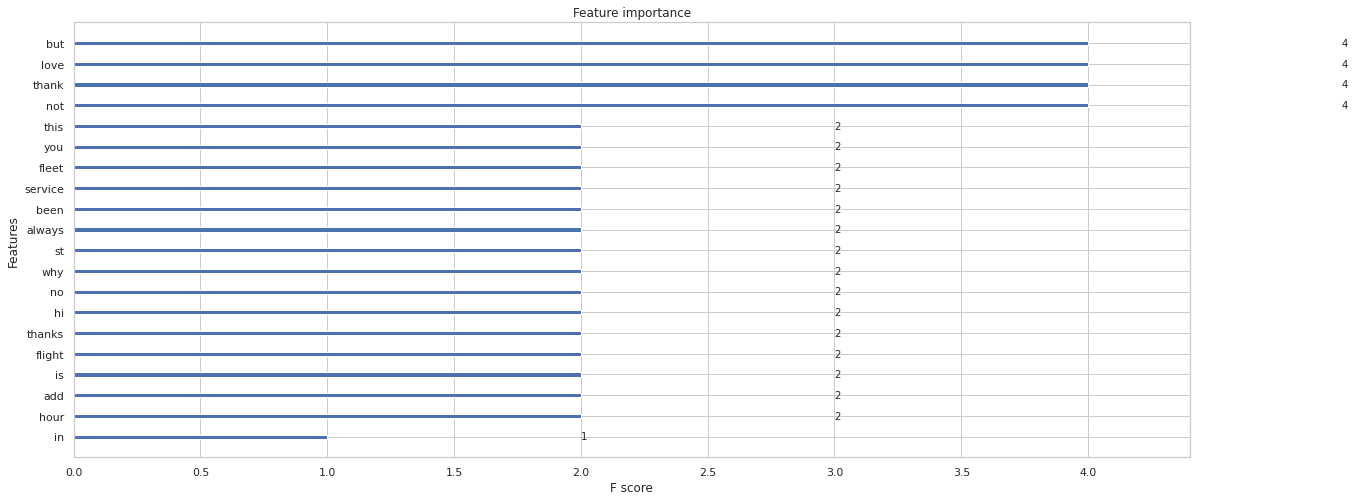

In [32]:
project3_model = xgb.train(params=parameters, 
                           dtrain=project3_dmatrix, 
                           num_boost_round=10)
ax1 = xgb.plot_importance(project3_model, max_num_features=20)
ax1.figure.set_size_inches(20, 8)
plt.show()

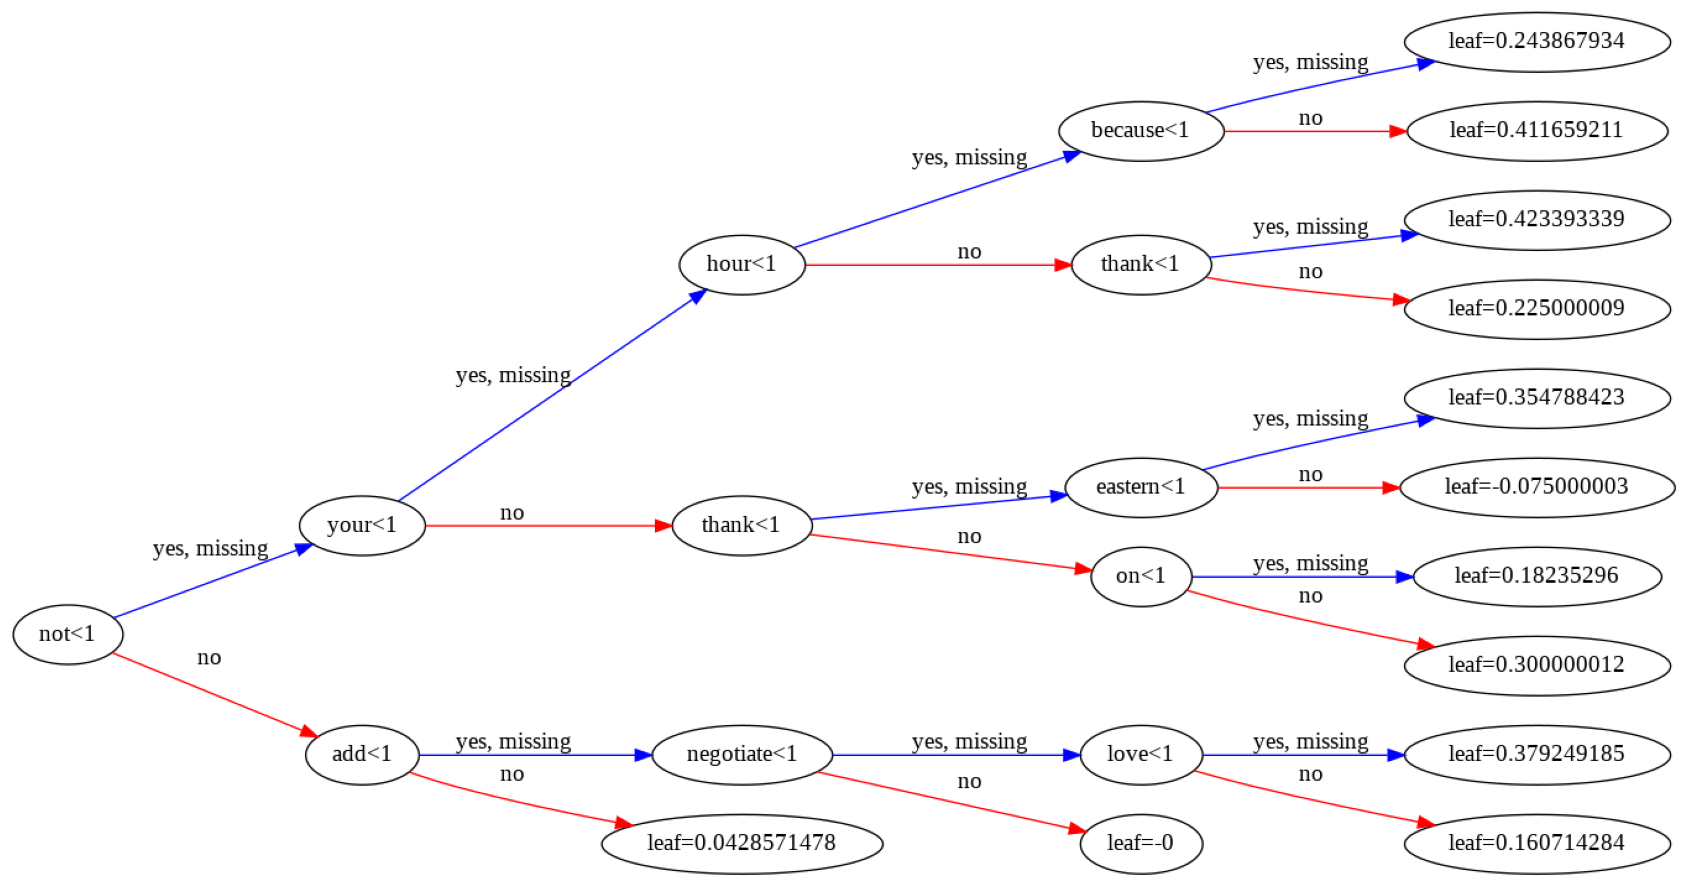

In [55]:
ax2 = xgb.plot_tree(project3_model, num_trees=0, rankdir="LR")
ax2.figure.set_size_inches(30,30)
plt.show()

In [ ]:
%%time
# simple xgboost regression
xg_reg = xgb.XGBClassifier(objective="reg:squarederror", seed=42, 
                          max_depth=2, silent=False, 
                          n_jobs=-1, colsample_bytree=0.8, 
                          gamma=0.1, learning_rate=0.3, 
                          min_child_weight=4, n_estimators=100)
xg_reg.fit(x_train, y_train)
y_predict = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))

CPU times: user 3min 45s, sys: 230 ms, total: 3min 46s
Wall time: 3min 46s


In [ ]:
print(f"Root Mean Square Error : {rmse:.3f}")
print(f"Train accuracy score   : {xg_reg.score(x_train, y_train):.4f}")
print(f"Test accuracy score    : {accuracy_score(y_test, y_predict):.4f}\n")

Root Mean Square Error : 0.837
Train accuracy score   : 0.7544
Test accuracy score    : 0.7480

